# Tariff Recommendation

### What type of new tariff (smart or ultra) is better for a customer


*Aim - as high accuracy as possible.*


- сalls — a number of calls,
- minutes — total duration of calls in minutes,
- messages — a number of sms,
- mb_used — Internet traffic consumed in MB,
- is_ultra — what tariff did the customer use during the month (“Ultra” - 1, “Smart” - 0).


## Content ##

[*Part 1. EDA*](#part1)

[*Part 2. Training*](#part2)

[*Part 3. Testing*](#part3)

## 1. EDA <a id='part1'></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.tree import DecisionTreeClassifier
import joblib
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import classification_report

In [2]:
data = pd.read_csv('classification_users_behavior (1).csv') 
data.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


In [3]:
data.head(10)

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
5,58.0,344.56,21.0,15823.37,0
6,57.0,431.64,20.0,3738.90,1
7,15.0,132.40,6.0,21911.60,0
8,7.0,43.39,3.0,2538.67,1
9,90.0,665.41,38.0,17358.61,0


In [4]:
data.describe()

,calls,minutes,messages,mb_used,is_ultra
count,3214.000000,3214.000000,3214.000000,3214.000000,3214.000000
mean,63.038892,438.208787,38.281269,17207.673836,0.306472
std,33.236368,234.569872,36.148326,7570.968246,0.461100
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,40.000000,274.575000,9.000000,12491.902500,0.000000
50%,62.000000,430.600000,30.000000,16943.235000,0.000000
75%,82.000000,571.927500,57.000000,21424.700000,1.000000
max,244.000000,1632.060000,224.000000,49745.730000,1.000000


The dataset has 3214 rows and 5 columns. Each row contains information about the behavior of one user for a month. The calls column contains information on the number of calls, minutes - the total duration of calls in minutes, messages - the number of SMS messages, mb_used - consumed Internet traffic in MB, is_ultra - what tariff you used during the month (“Ultra” - 1, “Smart” -0). In the first 4 columns, numbers are presented as floating point numbers, in the last - integer format.

In [5]:
data.corr() 

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


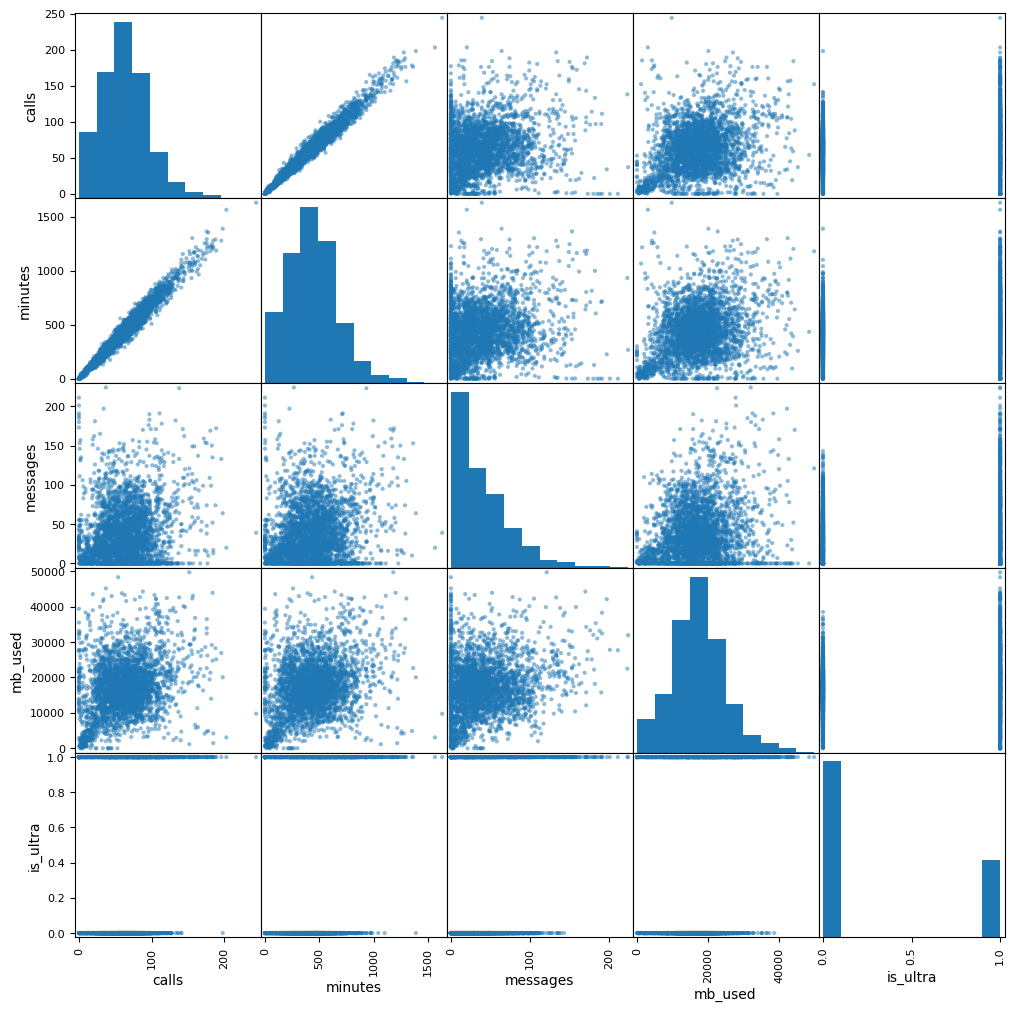

In [6]:
pd.plotting.scatter_matrix(data, figsize=(12, 12));

There is a strong direct relationship between call columns and call minutes.

From the table with correlation coefficients and from the graphs, the relationship between the number of calls and the minutes used stands out. A correlation coefficient of 0.98 indicates a strong relationship. The graphs confirm this. As the number of calls increases, the minutes of conversation also increase. When building models, we will only take into account the number of calls.

In [7]:
del data['minutes']

In [8]:
data.head()

,calls,messages,mb_used,is_ultra
0,40.0,83.0,19915.42,0
1,85.0,56.0,22696.96,0
2,77.0,86.0,21060.45,0
3,106.0,81.0,8437.39,1
4,66.0,1.0,14502.75,0


count    3214.000000
mean       63.038892
std        33.236368
min         0.000000
25%        40.000000
50%        62.000000
75%        82.000000
max       244.000000
Name: calls, dtype: float64

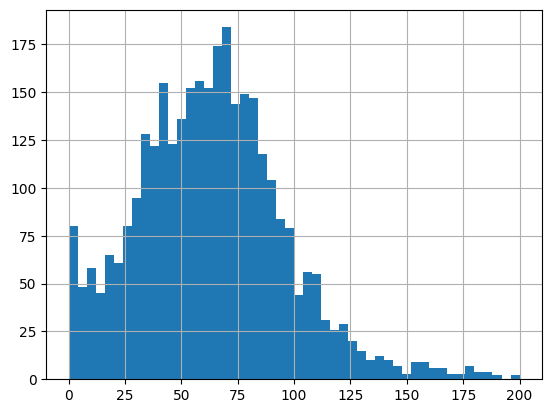

In [9]:
data['calls'].hist(bins=50, range = (0, 200));
data['calls'].describe()

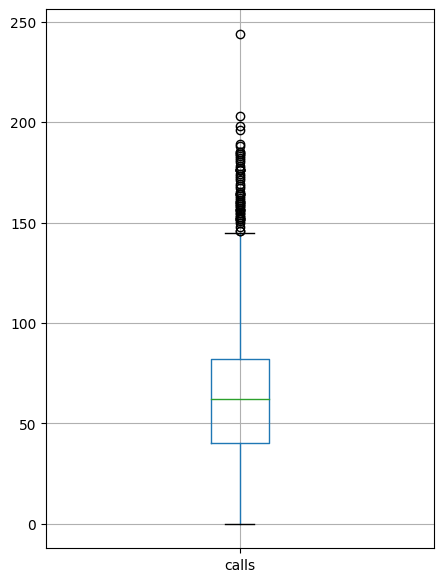

In [10]:
data.boxplot('calls', figsize=(5,7));

Based on the number of calls from the column description, it can be seen that the average number of calls is 63, median = 62, 75% of values are -82. Then there is a scattering of data, there are rare values above 150, this can be seen from the histogram and from the range diagram. We can assume that these are outliers; we will not take them into account further in the analysis so as not to distort the analysis.

count    3214.000000
mean       38.281269
std        36.148326
min         0.000000
25%         9.000000
50%        30.000000
75%        57.000000
max       224.000000
Name: messages, dtype: float64

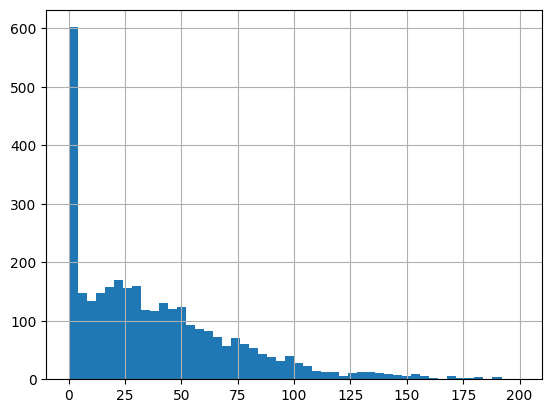

In [11]:
data['messages'].hist(bins=50, range = (0, 200))
data['messages'].describe()

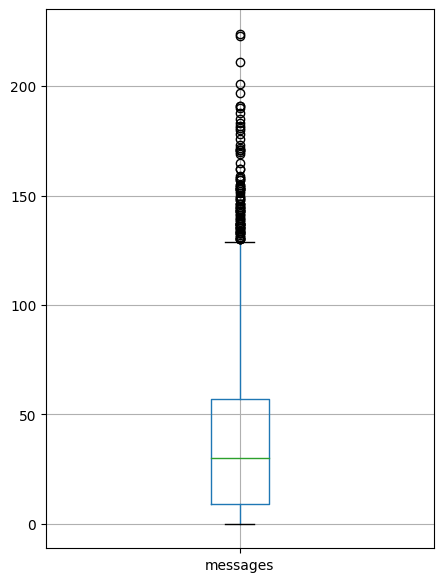

In [12]:
data.boxplot('messages', figsize=(5,7));

In the column with the number of messages, their average = 38, median = 30. 75% of values are 57. We will not take into account any further anomalous values over 125 messages.

count     3214.000000
mean     17207.673836
std       7570.968246
min          0.000000
25%      12491.902500
50%      16943.235000
75%      21424.700000
max      49745.730000
Name: mb_used, dtype: float64

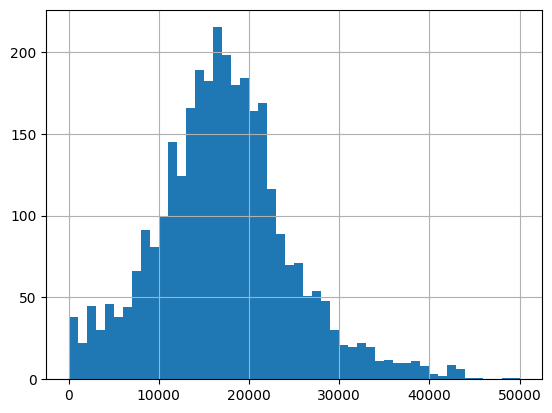

In [13]:
data['mb_used'].hist(bins=50, range = (0, 50000))
data['mb_used'].describe()

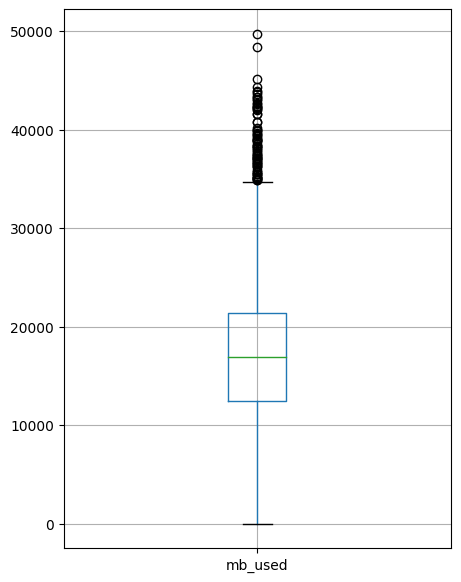

In [14]:
data.boxplot('mb_used', figsize=(5,7));

For the column with used Internet traffic, average = 17208 MB, median = 16943 MB, 75% of values - 21425. Values over 35000, which are anomalous, are excluded.

In [15]:
data['is_ultra'].value_counts()

is_ultra
0    2229
1     985
Name: count, dtype: int64

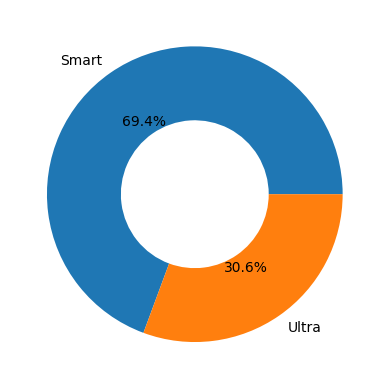

In [16]:
vals = [2229, 985]
labels = ["Smart", "Ultra"]
fig, ax = plt.subplots();
ax.pie(vals, labels=labels, autopct='%1.1f%%', wedgeprops=dict(width=0.5));

In [17]:
data = data.query('calls <= 150 and messages <= 125 and mb_used <= 35000')

In [18]:
data.describe()

,calls,messages,mb_used,is_ultra
count,3003.000000,3003.000000,3003.000000,3003.000000
mean,60.578422,34.264069,16460.931871,0.262737
std,29.284371,29.557809,6703.547675,0.440194
min,0.000000,0.000000,0.000000,0.000000
25%,40.000000,9.000000,12241.460000,0.000000
50%,61.000000,28.000000,16613.090000,0.000000
75%,80.000000,53.000000,20740.780000,1.000000
max,150.000000,125.000000,34912.320000,1.000000


During the exploratory analysis, we left those values that do not stand out strongly from our data, and removed the column with minutes used, which strongly correlates with the number of minutes used.

# 2. Training <a id='part2'></a>

In [19]:
from sklearn.model_selection import train_test_split

train=data.sample(frac=0.6,random_state=12345)
test_and_valid=data.drop(train.index)
test, valid = train_test_split(test_and_valid, test_size = 0.5, random_state=12345)

In [20]:
print(train.shape)
print(test.shape)
print(valid.shape)

(1802, 4)
(600, 4)
(601, 4)


We divided the data into 3 samples: training (60% of the values), based on which we will build the model. To check the model for the correctness of predictions - validation (20%), and for final verification - test (also 20%).

In [21]:
features_train = train.drop(['is_ultra'], axis=1) #explanatory var
target_train = train['is_ultra'] #target

features_valid = valid.drop(['is_ultra'], axis=1)
target_valid = valid['is_ultra']

features_test = test.drop(['is_ultra'], axis=1)
target_test = test['is_ultra']

Using statistical tests, we will check which features are most closely related to the target value.
Using the chi-square test, we will arrange the features in descending order of importance.

In [22]:
bestfeatures = SelectKBest (score_func = chi2, k = 3) 

In [23]:
fit = bestfeatures.fit(features_train, target_train) 

In [24]:
dfscores = pd.DataFrame(fit.scores_) 
dfcolumns = pd.DataFrame(features_train.columns)

In [25]:
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Signs','Score'] 
print(featureScores.nlargest(3,'Score'))

      Signs         Score
2   mb_used  18307.974570
0     calls    553.933291
1  messages    338.902364


[0.36554976 0.23650427 0.39794598]


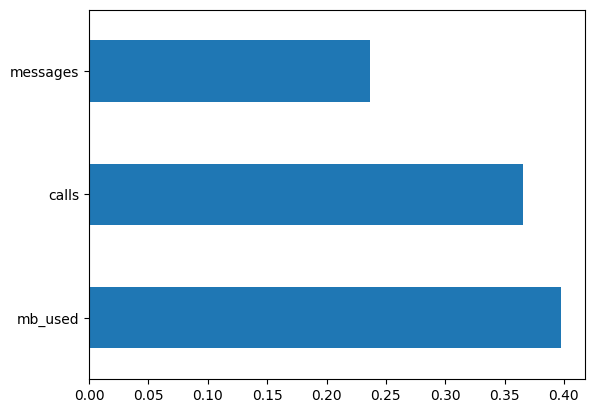

In [26]:
model = ExtraTreesClassifier()
model.fit(features_train, target_train)
print(model.feature_importances_)

feat_importances = pd.Series(model.feature_importances_, index=features_train.columns)
feat_importances.nlargest(3).plot(kind='barh');

The most important attribute was the used Internet traffic (0.4), followed by the number of calls (0.36), and in last place, messages (0.24).

In [27]:
#let's build the model with the tree depth from 2 to 16

for i in range(2,16):
    model_dec_tree_class = DecisionTreeClassifier(random_state=12345, max_depth=i, min_samples_split =10, min_samples_leaf =5, criterion = 'entropy')

    model_dec_tree_class.fit(features_train, target_train)
    
    predicted_valid = model_dec_tree_class.predict(features_valid) #predicted values with the validation set of data
    accuracy_valid = accuracy_score(target_valid, predicted_valid) #proportion of the right answers 
    
    print('depth = ' + str(i) + '. Accuracy_valid = ' + str(accuracy_valid))

depth = 2. Accuracy_valid = 0.762063227953411
depth = 3. Accuracy_valid = 0.762063227953411
depth = 4. Accuracy_valid = 0.7520798668885191
depth = 5. Accuracy_valid = 0.762063227953411
depth = 6. Accuracy_valid = 0.7670549084858569
depth = 7. Accuracy_valid = 0.7653910149750416
depth = 8. Accuracy_valid = 0.7737104825291181
depth = 9. Accuracy_valid = 0.7737104825291181
depth = 10. Accuracy_valid = 0.7420965058236273
depth = 11. Accuracy_valid = 0.757071547420965
depth = 12. Accuracy_valid = 0.757071547420965
depth = 13. Accuracy_valid = 0.7504159733777038
depth = 14. Accuracy_valid = 0.7520798668885191
depth = 15. Accuracy_valid = 0.7520798668885191


In [28]:
#random forest

for i in range(10,310, 10):
    model_rand_forest_class = RandomForestClassifier(random_state=12345, max_depth=10, n_estimators = i, verbose=0, min_samples_split =10, min_samples_leaf =5)

    model_rand_forest_class.fit(features_train, target_train)
    
    predicted_valid = model_rand_forest_class.predict(features_valid)
    accuracy_valid = accuracy_score(target_valid, predicted_valid)
    
    print('n_estimators = ' + str(i) + '. Accuracy_valid = ' + str(accuracy_valid))

n_estimators = 10. Accuracy_valid = 0.7853577371048253
n_estimators = 20. Accuracy_valid = 0.7853577371048253
n_estimators = 30. Accuracy_valid = 0.7853577371048253
n_estimators = 40. Accuracy_valid = 0.7803660565723793
n_estimators = 50. Accuracy_valid = 0.7770382695507487
n_estimators = 60. Accuracy_valid = 0.7820299500831946
n_estimators = 70. Accuracy_valid = 0.7853577371048253
n_estimators = 80. Accuracy_valid = 0.7853577371048253
n_estimators = 90. Accuracy_valid = 0.7853577371048253
n_estimators = 100. Accuracy_valid = 0.7820299500831946
n_estimators = 110. Accuracy_valid = 0.7803660565723793
n_estimators = 120. Accuracy_valid = 0.78369384359401
n_estimators = 130. Accuracy_valid = 0.78369384359401
n_estimators = 140. Accuracy_valid = 0.7853577371048253
n_estimators = 150. Accuracy_valid = 0.7853577371048253
n_estimators = 160. Accuracy_valid = 0.7853577371048253
n_estimators = 170. Accuracy_valid = 0.7870216306156406
n_estimators = 180. Accuracy_valid = 0.7886855241264559
n_est

In [29]:
#logistic regression

model_log_regr = LogisticRegression(random_state=12345)
model_log_regr.fit(features_train, target_train)

predicted_valid = model_log_regr.predict(features_valid)
accuracy_valid = accuracy_score(target_valid, predicted_valid)

print('Accuracy_valid = ' + str(accuracy_valid))

Accuracy_valid = 0.7221297836938436


 The best result was obtained from the random forest model (when testing various hyperparameters, the share of correct answers was brought to almost 0.79 with the number of trees = 180), the decision tree model is not far behind (with tree depth = 8, the share of correct answers = 0.77, in last place is the logistic regression model (share of correct answers - 0.72) Next, we will do a final check on the test sample.

# 3. Testing <a id='part3'></a>

In [30]:
#random forest testing

predicted_test_forest = model_rand_forest_class.predict(features_test)
accuracy_test = accuracy_score(target_test, predicted_test_forest)
print('Accuracy test of the best model:', accuracy_test)

Accuracy test of the best model: 0.8133333333333334


In [31]:
#decision tree testing

predicted_test_tree = model_dec_tree_class.predict(features_test)
accuracy_test = accuracy_score(target_test, predicted_test_tree)
print('Accuracy test of the Decision Tree model:', accuracy_test)

Accuracy test of the Decision Tree model: 0.7433333333333333


In [32]:
#logistic regression testing

predicted_test_log = model_log_regr.predict(features_test)
accuracy_test = accuracy_score(target_test, predicted_test_log)
print('Accuracy test of the Logistic Regression model:', accuracy_test)

Accuracy test of the Logistic Regression model: 0.7566666666666667


#### Accuracy checking and completeness depending on classes

*Classification report*

In [33]:
print(classification_report(predicted_test_forest, target_test))

              precision    recall  f1-score   support

           0       0.95      0.83      0.89       520
           1       0.39      0.71      0.50        80

    accuracy                           0.81       600
   macro avg       0.67      0.77      0.69       600
weighted avg       0.87      0.81      0.83       600



According to the Random Forest Classification Report, checking it using the test data, we have gotten not that bad results. 

Smart Tariff (0): f1-score (harmonic mean of precision and recall) = 0.89, recall = 0.83, precision = 0.95. 

Ultra Tariff (1): 0.50, 0.71, 0.39 accordingly. 

Accuracy (the proportion of correct answers) = 0.81

In [34]:
print(classification_report(predicted_test_tree, target_test))

              precision    recall  f1-score   support

           0       0.87      0.81      0.84       488
           1       0.36      0.46      0.40       112

    accuracy                           0.74       600
   macro avg       0.61      0.64      0.62       600
weighted avg       0.77      0.74      0.76       600



When checking the decision tree model, all the indicated parameters are lower, as well as for the logistic regression model, which failed with the Ultra tariff.

In [35]:
print(classification_report(predicted_test_log, target_test))

              precision    recall  f1-score   support

           0       1.00      0.76      0.86       600
           1       0.00      0.00      0.00         0

    accuracy                           0.76       600
   macro avg       0.50      0.38      0.43       600
weighted avg       1.00      0.76      0.86       600



C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Anzhelika Soldatova\anaconda3\envs\new_environment\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

Final result: the highest values when checking the test sample were achieved for the random forest model. The accuracy indicator was 0.81.

*We can also check the adequacy of the model*

In [36]:
data['is_ultra'].value_counts() / data.shape[0] #let's calculate the shares of ultra and smart tariffs in the total number

is_ultra
0    0.737263
1    0.262737
Name: count, dtype: float64

or

In [37]:
class1 = data['is_ultra'].value_counts() / data['is_ultra'].count()
class1

is_ultra
0    0.737263
1    0.262737
Name: count, dtype: float64

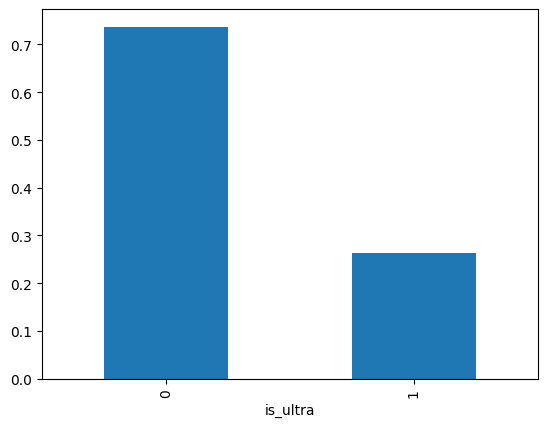

In [38]:
class1.plot(kind='bar');

As a result, the accuracy of the best model (0.81) > accuracy of appearance 0 (accuracy, fraction = 0.74) => our random forest model predicts better => the model is adequate for use.